In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np

In [3]:
np.random.seed(777)

In [4]:
df = pd.read_excel('datasets/ep1_esic2023_clareza_TRAIN.xlsx')
df.head()

,resp_text,clarity
0,Prezado Sr Jose Taunai Em atenção ao seu pe...,c5
1,"""A pedido do Pró-Reitor de Graduação, informa...",c5
2,"""Prezado (a) Sr. (a), Agradecemos o contato e...",c234
3,"""Prezado (a) Sr. (a), Agradecemos o contato e...",c234
4,"""Prezado Prof. Gilberto Tadeu Reis da Silva ...",c234


In [5]:
df.describe()

,resp_text,clarity
count,6000,6000
unique,5626,3
top,"Prezado(a) Senhor(a), Sua manifestação foi a...",c5
freq,41,2000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   resp_text  6000 non-null   object
 1   clarity    6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


## Pré-processamento

### 0. Reordenar baseado no rótulo 'clarity' (opcional)

In [7]:
df.sort_values(by='clarity', ascending=True, inplace=True, ignore_index=True)
df.head()

,resp_text,clarity
0,"Prezada Senhora, Informa-se que o DNIT é uma ...",c1
1,"Prezada, Os dados se referem somente aos na...",c1
2,"Prezado Usuário, Inicialmente agradecemos o s...",c1
3,"Prezada, Referimo-nos a sua demanda, regist...",c1
4,"Prezada, Segue anexa a resposta da área com...",c1


### 1. Remover linhas vazias ou nulas, se existirem

In [8]:
df['resp_text'].dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   resp_text  6000 non-null   object
 1   clarity    6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


não tinhamos nenhuma linha vazia ou nula

### 2. Mudar todas as letras para caixa baixa

In [10]:
df['resp_text'] = [resp.lower() for resp in df['resp_text']]
df.sample()

,resp_text,clarity
2240,"prezado senhor, em atenção a solicitação ...",c234


### 3. Tokenização

In [11]:
from nltk.tokenize import word_tokenize

In [12]:
df_tokenized = df
df_tokenized['tokens'] = [word_tokenize(resp) for resp in df['resp_text']]

In [13]:
df_tokenized.head(10)

,resp_text,clarity,tokens
0,"prezada senhora, informa-se que o dnit é uma ...",c1,"[prezada, senhora, ,, informa-se, que, o, dnit..."
1,"prezada, os dados se referem somente aos na...",c1,"[prezada, ,, os, dados, se, referem, somente, ..."
2,"prezado usuário, inicialmente agradecemos o s...",c1,"[prezado, usuário, ,, inicialmente, agradecemo..."
3,"prezada, referimo-nos a sua demanda, regist...",c1,"[prezada, ,, referimo-nos, a, sua, demanda, ,,..."
4,"prezada, segue anexa a resposta da área com...",c1,"[prezada, ,, segue, anexa, a, resposta, da, ár..."
5,"prezada, segue anexa a resposta da área com...",c1,"[prezada, ,, segue, anexa, a, resposta, da, ár..."
6,"prezada, segue em anexo resposta da área té...",c1,"[prezada, ,, segue, em, anexo, resposta, da, á..."
7,"prezado usuário, segue anexa resposta do seto...",c1,"[prezado, usuário, ,, segue, anexa, resposta, ..."
8,"prezada, segue resposta ao seu pedido de in...",c1,"[prezada, ,, segue, resposta, ao, seu, pedido,..."
9,"prezado usuário, enviamos a resposta apresent...",c1,"[prezado, usuário, ,, enviamos, a, resposta, a..."


### 4. Lemmatização

In [14]:
import spacy
import os

try:
    nlp = spacy.load("pt_core_news_sm")
except Exception:
    os.system("python -m spacy download pt_core_news_sm")
    nlp = spacy.load("pt_core_news_sm")

In [15]:
df_lemma = df
filtered = []
for sent in df['resp_text']:
    sent = str(sent)
    doc = nlp(sent)
    temp = [token.lemma_ for token in doc if not token.is_punct]
    temp = " ".join(temp)
    filtered.append(temp)

KeyboardInterrupt: 

In [16]:
df_lemma['lemma'] = filtered

In [17]:
df_lemma.head()

,resp_text,clarity,tokens,lemma
0,"prezada senhora, informa-se que o dnit é uma ...",c1,"[prezada, senhora, ,, informa-se, que, o, dnit...",prezar senhora informar se que o dnit ser um...
1,"prezada, os dados se referem somente aos na...",c1,"[prezada, ,, os, dados, se, referem, somente, ...",prezar o dado se referir somente a o nasc...
2,"prezado usuário, inicialmente agradecemos o s...",c1,"[prezado, usuário, ,, inicialmente, agradecemo...",prezar usuário inicialmente agradecer o seu ...
3,"prezada, referimo-nos a sua demanda, regist...",c1,"[prezada, ,, referimo-nos, a, sua, demanda, ,,...",prezar referimo-nos o seu demanda registr...
4,"prezada, segue anexa a resposta da área com...",c1,"[prezada, ,, segue, anexa, a, resposta, da, ár...",prezar seguir anexo o resposta de o área ...


## Separação de treino e teste

In [18]:
from sklearn.model_selection import train_test_split

In [44]:
main = df_lemma

X = main[['lemma']]
y = main[['clarity']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=main['clarity'])

<Axes: ylabel='clarity'>

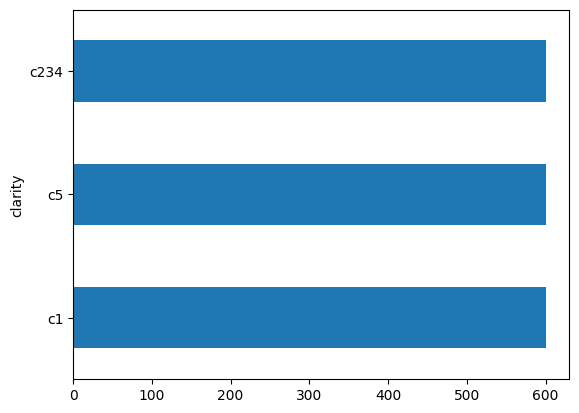

In [45]:
y_test['clarity'].value_counts().plot(kind='barh')


### Enconding do rótulo

In [21]:
from sklearn.preprocessing import LabelEncoder

In [46]:
import warnings

warnings.filterwarnings("ignore")

Encoder = LabelEncoder()

y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

## Vetorização de palavras

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(main['lemma'])

X_train_Tfidf = Tfidf_vect.transform(X_train['lemma'])
X_test_Tfidf = Tfidf_vect.transform(X_test['lemma'])

### Naive Bayes

In [33]:
from sklearn.model_selection import cross_val_score

In [53]:
from sklearn import naive_bayes

Naive = naive_bayes.MultinomialNB()

scores = cross_val_score(Naive, X_train_Tfidf, y_train, cv=10)

print(scores)
scores.mean()

[0.53809524 0.53333333 0.57380952 0.53333333 0.5452381  0.51190476
 0.54047619 0.52619048 0.5547619  0.57142857]


0.5428571428571428

mto ruim eu acho

### SVM

In [54]:
from sklearn import svm

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

scores = cross_val_score(SVM, X_train_Tfidf, y_train, cv=10)

print(scores)
scores.mean()

[0.55952381 0.56428571 0.59761905 0.55238095 0.57619048 0.53809524
 0.52380952 0.55714286 0.56190476 0.55714286]


0.5588095238095238

In [55]:
from sklearn.metrics import accuracy_score

SVM.fit(X_train_Tfidf, y_train)

y_pred = SVM.predict(X_test_Tfidf)

accuracy_score(y_pred=y_pred, y_true=y_test)

0.5722222222222222

não tão mlr assim, ctz que tem algo errado

### Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
scores = cross_val_score(RF, X_train_Tfidf, y_train, cv=10)

print(scores)
scores.mean()


[0.5452381  0.52380952 0.56666667 0.54047619 0.55714286 0.51190476
 0.55238095 0.54761905 0.56904762 0.5952381 ]


0.550952380952381

meio fezes tbm

In [57]:
SVM.fit(X_train_Tfidf, y_train)
result = SVM.score(X_test_Tfidf, y_test)
print(result)

0.5722222222222222


## Relação entre tamanho do texto e claridade

In [58]:
text_size = df['resp_text'].str.len()
df['text_size'] = text_size
df['clarity_new'] = df['clarity'].replace(['c1', 'c234', 'c5'], [0,1,2])
df['clarity_new'] = df['clarity_new'].astype('int64')
df['clarity_new'].corr(df['text_size'])

-0.10332829414456454

legal, n tem correlaçãokkkkk

In [59]:
df = df[['resp_text', 'clarity']]